<a href="https://colab.research.google.com/github/RaymondPTrain/ml/blob/master/GANProj4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Visualizing what convnets learn

Adapted from various tensorflow and keras tutorials

## First visualize the filters



In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Setup


In [5]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 180
img_height = 180

layer_name = "block3_conv3"


In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path,target_size=(180,180))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img /255


In [6]:
base_image_path = '/content/gdrive/My Drive/zebraroad.jpg'
local_img = preprocess_image(base_image_path)
local_img.shape


(1, 180, 180, 3)

## Build a feature extraction model


In [9]:
# Build a VGG16 model loaded with pre-trained ImageNet weights

model = keras.applications.VGG16(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)


In [10]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.


In [11]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)



Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.


In [12]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img



## Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.


In [13]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    #img = np.random.random((1, 3, img_width, img_height)) * 20 + 128.
    #img = local_img
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    #return (img * .25) + .5
    return (img - 0.5) * 0.25
    #return (img - 127 ) / 128


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    #img=local_img
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img



Let's try it out with filter 0 in the target layer:


In [14]:
from IPython.display import Image, display

loss, img = visualize_filter(4)
keras.preprocessing.image.save_img("0.png", img)


This is what an input that maximizes the response of filter 0 in the target layer would
look like:


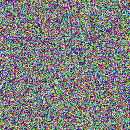

In [15]:
display(Image("0.png"))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


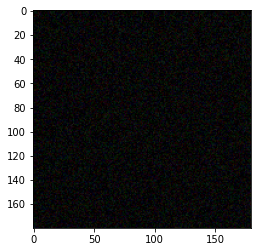

In [16]:
ti = initialize_image()
from matplotlib import pyplot as plt
plt.imshow(ti[0])
#ti

In [17]:
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Visualize the first 16 filters in the target layer

Now, let's make a 4x4 grid of the first 16 filters
in the target layer to get of feel for the range
of different visual patterns that the model has learned.


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15


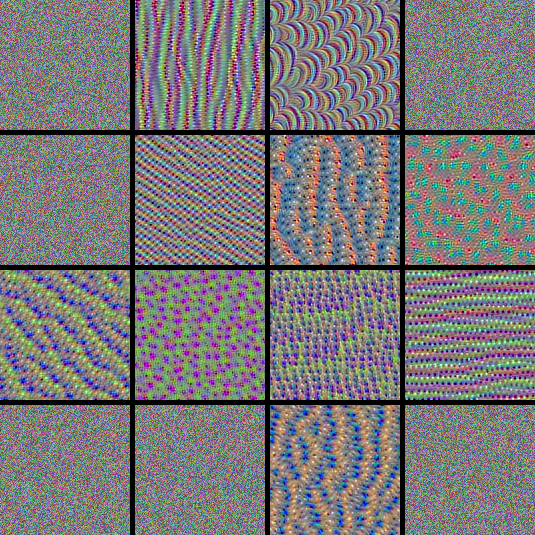

In [18]:
# Compute image inputs that maximize per-filter activations
# for the first 16filters of our target layer
all_imgs = []
for filter_index in range(16):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 4
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))


# Now for the Grad-CAM

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm



In [20]:
model = keras.applications.VGG16(weights="imagenet", include_top=True)

553467904/553467096 [==============================] - 10s 0us/step


## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` and `classifier_layer_names`, use
 `model.summary()` to see the names of all layers in the model.


array([[[[0.972549  , 0.8784314 , 0.87058824],
         [0.95686275, 0.80784315, 0.8039216 ],
         [0.85490197, 0.68235296, 0.64705884],
         ...,
         [0.654902  , 0.5411765 , 0.38431373],
         [0.7019608 , 0.57254905, 0.37254903],
         [0.69803923, 0.6117647 , 0.3882353 ]],

        [[0.972549  , 0.8784314 , 0.87058824],
         [0.972549  , 0.8901961 , 0.87058824],
         [0.39607844, 0.27450982, 0.25490198],
         ...,
         [0.69411767, 0.5803922 , 0.42352942],
         [0.5411765 , 0.41960785, 0.29803923],
         [0.61960787, 0.5019608 , 0.36078432]],

        [[0.9607843 , 0.8392157 , 0.827451  ],
         [0.972549  , 0.8901961 , 0.8784314 ],
         [0.92941177, 0.74509805, 0.7058824 ],
         ...,
         [0.7019608 , 0.56078434, 0.4745098 ],
         [0.5647059 , 0.44313726, 0.32941177],
         [0.5647059 , 0.48235294, 0.3137255 ]],

        ...,

        [[0.6392157 , 0.4509804 , 0.40392157],
         [0.15294118, 0.1882353 , 0.18431373]

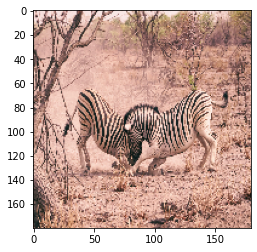

In [22]:
from keras.preprocessing.image import load_img, save_img, img_to_array
#model_builder = keras.applications.xception.Xception
model_builder = keras.applications.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions
#preprocess_input = tf.keras.applications.VGG16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

#last_conv_layer_name = "block14_sepconv2_act"
last_conv_layer_name = "block5_pool"
classifier_layer_names = ["flatten","fc1",
    "fc2",
    "predictions",
]

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path,target_size=(180,180))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #  img = inception_v3.preprocess_input(img)
    return img /255

local_img = preprocess_image('/content/gdrive/My Drive/zebra.jpg')

# The local path to our target image
#img_path = keras.utils.get_file('zebra',' felephant_cam.jpg'
 #   "african_elephant.jpg", " https://mediad.publicbroadcasting.net/p/idaho/files/styles/large/public/201902/Groundhog.jpg"
#)
#img_path = '/content/gdrive/My Drive/zebra.jpg'
#img_path = "/content/gdrive/My Drive/cactus.jpg"
display(local_img)
#display(Image(img_path))
plt.imshow(local_img[0])


And a random image from the net to test

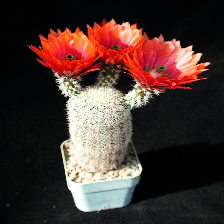

In [24]:
img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
img

In [25]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



40960/35363 [==================================] - 0s 0us/step
Predicted: [('n03788365', 'mosquito_net', 0.048714507), ('n15075141', 'toilet_tissue', 0.040102046), ('n04209239', 'shower_curtain', 0.017282877), ('n03291819', 'envelope', 0.016582945), ('n04522168', 'vase', 0.013941982)]


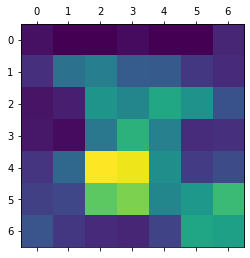

In [26]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=5)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()



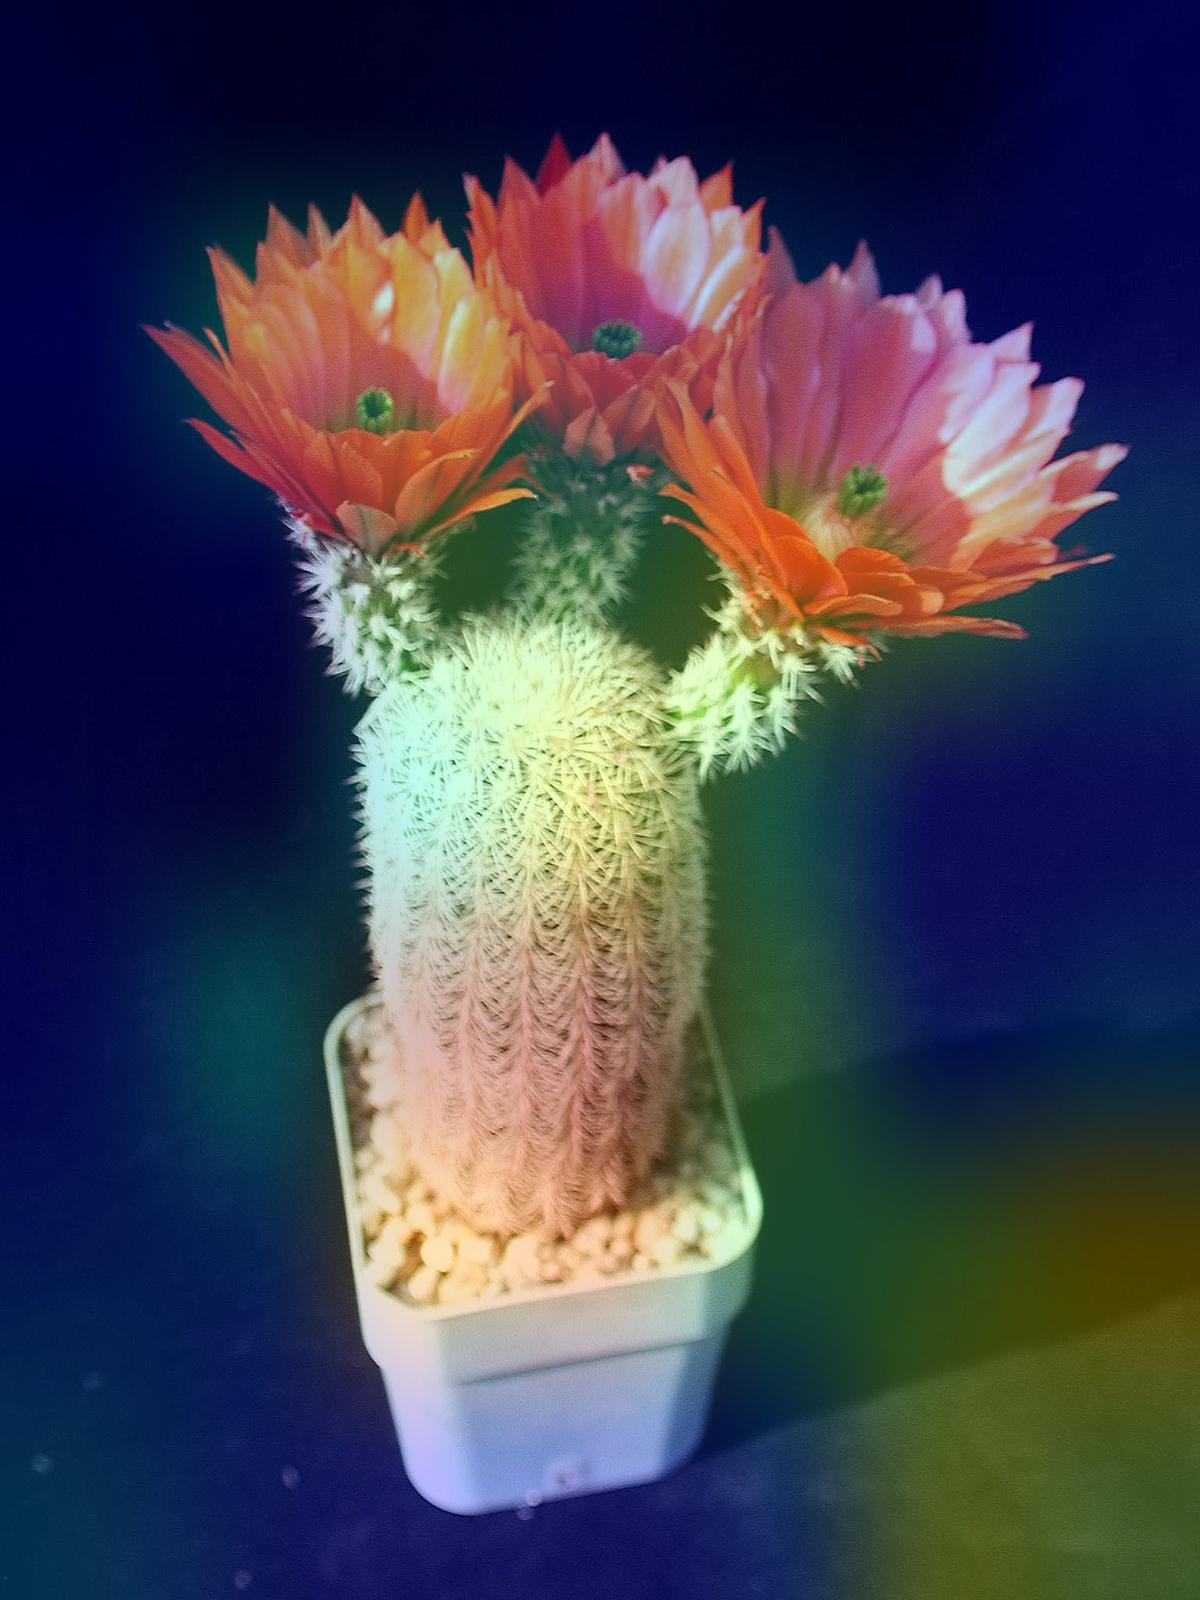

In [27]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))


End of Grad-Cam section

It looks like the heatmap picks up the relevant parts of the image, but it doesn't really see the right class.   Maybe the black background or the orientation is an issue.     Come back to this and try some other images.